# Customer Segmentation Using K-Means Clustering

### Importing Required Libraries

We begin by importing the necessary Python libraries used throughout the customer segmentation project:
- **NumPy** and **Pandas** are used for numerical operations and data manipulation.
- **Matplotlib** and **Seaborn** help in creating visualizations.
- **KMeans** from scikit-learn is used to perform clustering on customer behavior data.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Loading the Dataset

The dataset is loaded using `pd.read_excel()`, which reads Excel files into a DataFrame. A copy of the original dataset is made to preserve the raw data (`raw_df`) for reference, while `df` will be used for data cleaning and transformation. The `.head()` function displays the first few rows to understand the data structure.

In [2]:
raw_df = pd.read_excel('/Users/vardhanvarikuti/Programming Files/INT375DSToolbox/Online Retail.xlsx')

### Dataset Description

The dataset contains online retail transaction records. Each row represents a product purchased in a transaction. Below are key attributes:

- **InvoiceNo**: Unique identifier for each transaction.
- **StockCode**: Unique product/item code.
- **Description**: Description of the product.
- **Quantity**: Number of units purchased.
- **InvoiceDate**: Date and time when the transaction occurred.
- **UnitPrice**: Price per unit (in pounds).
- **CustomerID**: Unique identifier for each customer.
- **Country**: Country of the customer.

### Initial Data Overview

We start by creating a copy of the original dataset to preserve the raw data. Using `df.head()`, we preview the first few rows to understand the structure of the dataset. The `df.info()` function provides a concise summary of the dataframe, including the column names, data types, and number of non-null values. This helps us identify any missing values or data type issues that might need preprocessing.


In [3]:
df = raw_df.copy()
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### Data Cleaning and Feature Engineering

In this step, we remove transactions with missing `CustomerID`, as they cannot be associated with any customer for analysis. We then convert `CustomerID` to an integer for consistency. A new feature `TotalPrice` is computed to represent the total amount spent per transaction. Additionally, we create a boolean feature `IsCanceled` to flag canceled transactions, identified by invoice numbers starting with 'C'. This prepares our dataset for more accurate customer analysis.


In [4]:
df = df.dropna(subset = ['CustomerID'])   # remove rows without customer ID
df['CustomerID'] = df['CustomerID'].astype(int)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']  # Added a colmun of Amount spent for each purchase
df['IsCanceled'] = df['InvoiceNo'].astype(str).str.startswith('C')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  object        
 8   TotalPrice   406829 non-null  float64       
 9   IsCanceled   406829 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 31.4+ MB


### Identify Total Spending Per Customer

We calculate the total amount each customer has spent by grouping the dataset by `CustomerID` and summing the `TotalPrice`. This gives us a sense of overall customer value and helps identify high-value customers. This step is foundational for deeper segmentation and analysis such as RFM and clustering.


In [5]:
# Total spending per customer
customer_spending = df.groupby('CustomerID')['TotalPrice'].sum().reset_index().rename(columns={'TotalPrice': 'TotalSpent'})
customer_spending

,CustomerID,TotalSpent
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40
...,...,...
4367,18280,180.60
4368,18281,80.82
4369,18282,176.60
4370,18283,2094.88


### Total Number of Orders per Customer

Here, we calculate how many unique orders (`InvoiceNo`) each customer placed. This metric reflects purchase frequency and helps us better understand customer behavior. Combined with total spending, it highlights not just *who* spends the most, but *how often* they engage with the business.


In [6]:
# Number of orders per customer
orders_per_customer = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo': 'TotalOrders'})
orders_per_customer

,CustomerID,TotalOrders
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1
...,...,...
4367,18280,1
4368,18281,1
4369,18282,3
4370,18283,16


### Distribution of Orders per Customer

This histogram shows how frequently customers place orders, with a logarithmic scale on the y-axis to handle the skewed distribution. Most customers place a small number of orders, but a few make significantly more, highlighting a core group of repeat buyers.


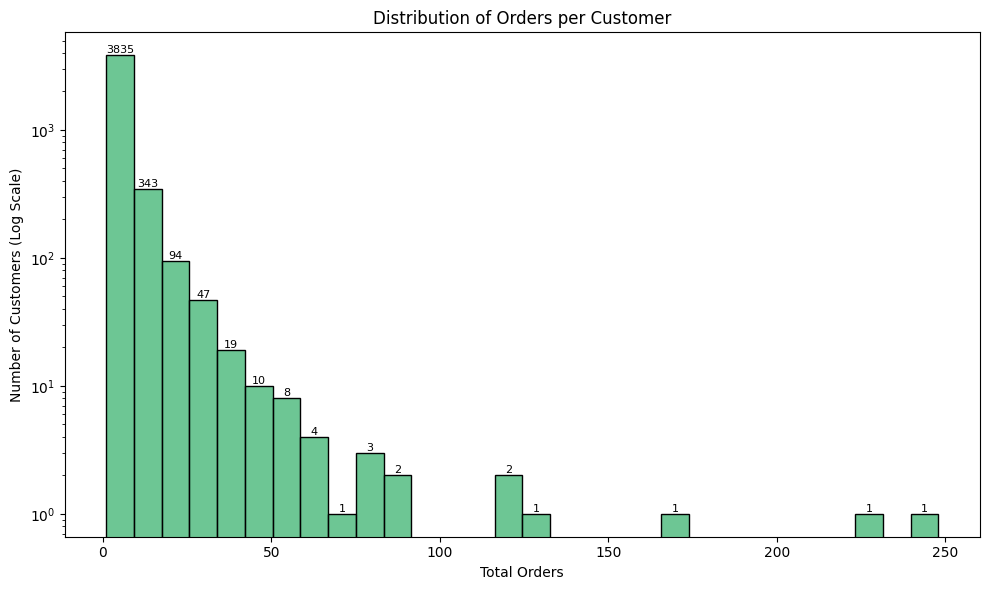

In [7]:
plt.figure(figsize=(10,6))
ax = sns.histplot(orders_per_customer['TotalOrders'], bins=30, kde=False, color='mediumseagreen')
plt.yscale('log')

# Annotate counts on bars
for rect in ax.patches:
    height = rect.get_height()
    if height > 0:
        ax.text(
            rect.get_x() + rect.get_width()/2,
            height,
            f"{int(height)}",
            ha='center',
            va='bottom',
            fontsize=8
        )

plt.title('Distribution of Orders per Customer')
plt.xlabel('Total Orders')
plt.ylabel('Number of Customers (Log Scale)')
plt.tight_layout()
plt.show()


### Customer Spending Behavior — Basket Size

We first clean the dataset by removing canceled transactions (invoices starting with 'C'). Then we calculate the basket size by grouping non-canceled orders (`InvoiceNo`) and summing up the quantity of items in each. This helps understand how much customers typically buy per order, which can be valuable for planning inventory and promotions.


In [8]:
df_clean = df[~df['InvoiceNo'].astype(str).str.startswith('C')] #Datframe without cancled data
basket_size = df_clean.groupby('InvoiceNo')['Quantity'].sum().reset_index().rename(columns={'Quantity': 'BasketSize'})
basket_size

,InvoiceNo,BasketSize
0,536365,40
1,536366,12
2,536367,83
3,536368,15
4,536369,3
...,...,...
18531,581583,76
18532,581584,120
18533,581585,278
18534,581586,66


### Top 10 Customer by Total Spending

This bar chart visualizes the top 10 customers with the highest total spending. It helps identify the most valuable customers whose loyalty can significantly influence overall revenue.


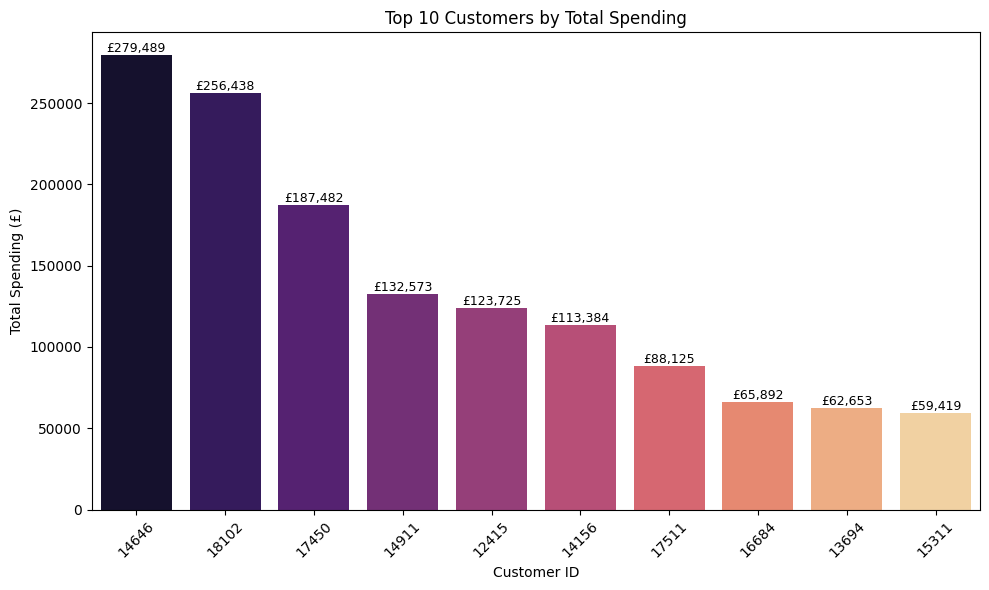

In [9]:
# Top 10 customers by total spending 
top_customers = customer_spending.nlargest(10, 'TotalSpent')
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=top_customers, 
    x='CustomerID', 
    y='TotalSpent', 
    palette='magma',
    order=top_customers.sort_values('TotalSpent', ascending=False)['CustomerID'].astype(str)
)

for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'£{height:,.0f}', ha='center', va='bottom', fontsize=9)

plt.title('Top 10 Customers by Total Spending')
plt.xlabel('Customer ID')
plt.ylabel('Total Spending (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Analyze Overall Customer Spending Behavior — Canceled Orders

This table calculates how many orders each customer has canceled. By analyzing the number of cancellations per customer, businesses can identify potential issues in service, product satisfaction, or customer behavior. This insight helps improve the return or refund policies and manage high-risk customer segments.


In [10]:
canceled_orders = df[df['IsCanceled']].groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo': 'CanceledOrders'})
canceled_orders

,CustomerID,CanceledOrders
0,12346,1
1,12352,3
2,12359,2
3,12362,3
4,12365,1
...,...,...
1584,18272,1
1585,18274,1
1586,18276,2
1587,18277,1


### Distribution of Basket Size per Order

This histogram shows how many items are typically purchased per order (basket size), excluding canceled transactions. The log scale on the y-axis reveals a large number of small purchases, with a few orders containing significantly more items. This insight helps identify bulk buyers or potentially fraudulent behavior.

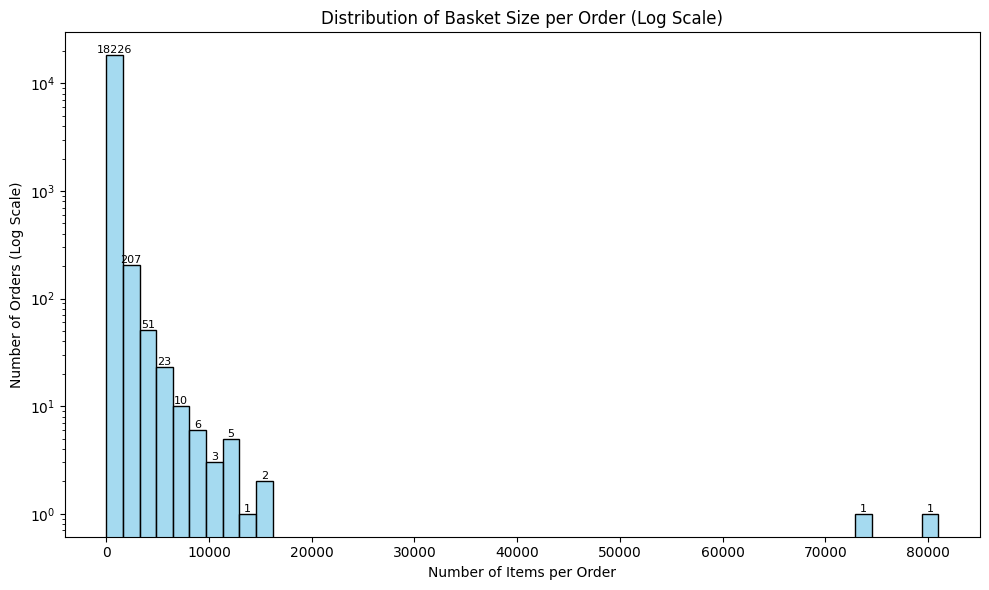

In [11]:
plt.figure(figsize=(10,6))
ax = sns.histplot(basket_size['BasketSize'], bins=50, color='skyblue')
plt.yscale('log')

# Annotate counts on bars
for rect in ax.patches:
    height = rect.get_height()
    if height > 0:
        ax.text(
            rect.get_x() + rect.get_width()/2,
            height,
            f"{int(height)}",
            ha='center',
            va='bottom',
            fontsize=8)
        
plt.title('Distribution of Basket Size per Order (Log Scale)')
plt.xlabel('Number of Items per Order')
plt.ylabel('Number of Orders (Log Scale)')
plt.tight_layout()
plt.show()

### Combine Customer Behavior Metrics

We merge multiple customer-related metrics—total spending, total orders, and canceled orders—into a single DataFrame using an outer join on `CustomerID`. This ensures all available behavioral data is combined. Missing values for canceled orders are filled with 0, and any remaining missing entries are dropped to prepare for clean analysis.


In [12]:
from functools import reduce
dfs = [customer_spending, orders_per_customer, canceled_orders]
customer_behavior = reduce(lambda left, right: pd.merge(left, right, on='CustomerID', how='outer'), dfs)

customer_behavior['CanceledOrders'] = customer_behavior['CanceledOrders'].fillna(0).astype(int)

customer_behavior = customer_behavior.dropna()

customer_behavior.head()

,CustomerID,TotalSpent,TotalOrders,CanceledOrders
0,12346,0.00,2,1
1,12347,4310.00,7,0
2,12348,1797.24,4,0
3,12349,1757.55,1,0
4,12350,334.40,1,0


### Distribution of Canceled Orders per Customer

This histogram shows how many canceled orders customers have made. The y-axis is displayed on a log scale to better visualize the wide range of customer counts across different cancelation levels. Annotations on each bar help interpret the actual values. This view is useful for identifying if cancellations are common or concentrated among a few customers.

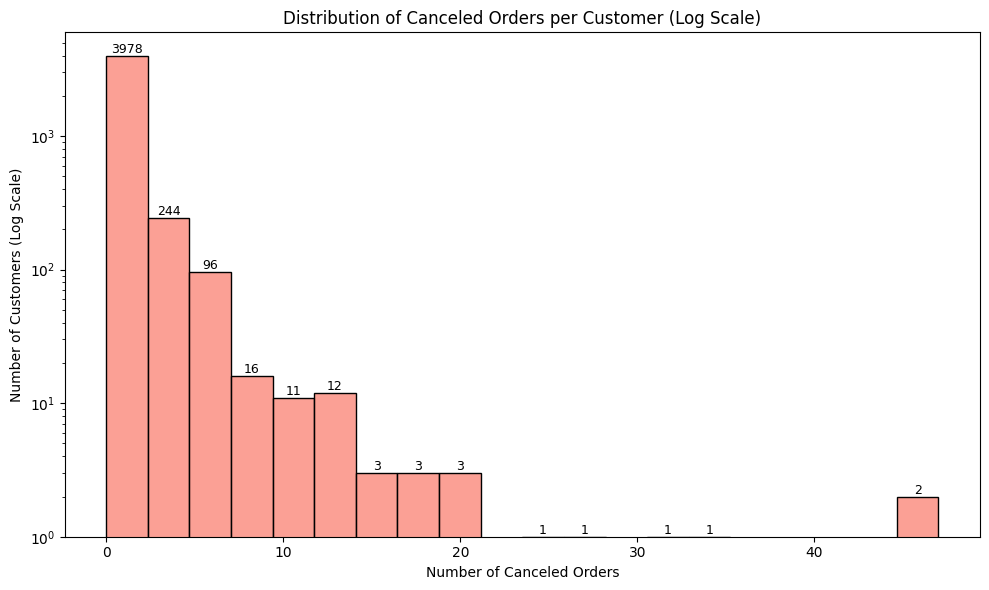

In [13]:
plt.figure(figsize=(10,6))
ax = sns.histplot(customer_behavior['CanceledOrders'], bins=20, kde=False, color='salmon')
plt.yscale('log')

# Set y-axis limit slightly above the tallest bar
max_height = max([rect.get_height() for rect in ax.patches])
plt.ylim(1, max_height * 1.5)

# Add annotations on top of each bin
for rect in ax.patches:
    height = rect.get_height()
    if height > 0:
        plt.text(
            rect.get_x() + rect.get_width()/2,
            height,
            f"{int(height)}",
            ha='center',
            va='bottom',
            fontsize=9)

plt.title('Distribution of Canceled Orders per Customer (Log Scale)')
plt.xlabel('Number of Canceled Orders')
plt.ylabel('Number of Customers (Log Scale)')
plt.tight_layout()
plt.show()


### Monthly Revenue Analysis

This line plot shows how revenue has changed over time by aggregating total sales (`TotalPrice`) on a monthly basis. It helps identify seasonal trends, business growth, or potential drops in customer purchasing behavior. A steady or increasing line indicates healthy customer engagement, while sudden dips might suggest churn or seasonal fluctuations that need to be investigated.


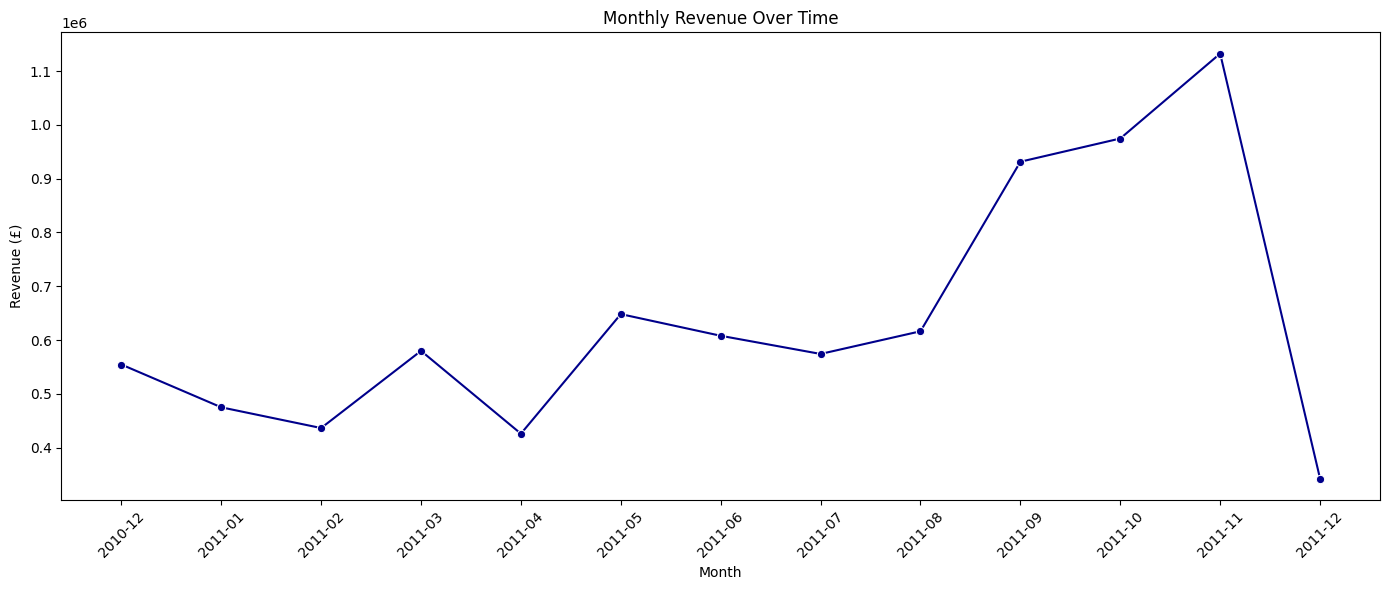

In [14]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
# Monthly Revenue
monthly_revenue = df.groupby('InvoiceMonth')['TotalPrice'].sum().reset_index()
monthly_revenue['InvoiceMonth'] = monthly_revenue['InvoiceMonth'].astype(str)

plt.figure(figsize=(14,6))
sns.lineplot(data=monthly_revenue, x='InvoiceMonth', y='TotalPrice', marker='o', color='darkblue')
plt.title('Monthly Revenue Over Time')
plt.xlabel('Month')
plt.ylabel('Revenue (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top 10 Countries by Revenue

This horizontal bar chart highlights the top 10 countries based on total revenue generated. It offers insight into where the majority of sales come from, helping businesses identify their strongest markets. This analysis is useful for targeting promotions, tailoring marketing strategies, and exploring new growth opportunities in high-performing regions.


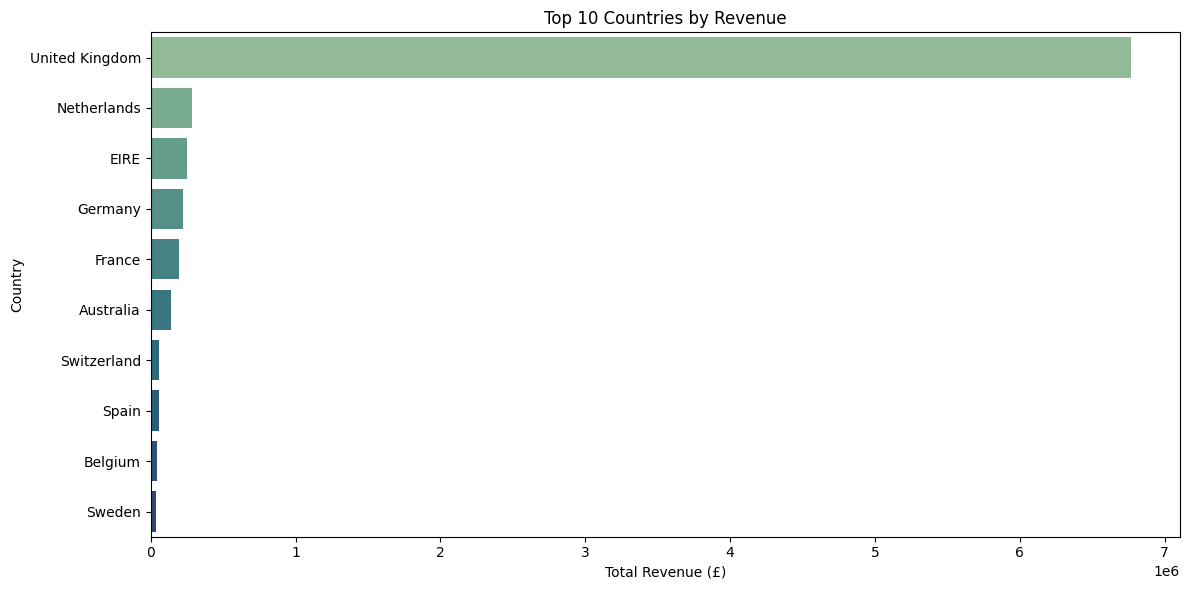

In [15]:
country_revenue = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=country_revenue.values, y=country_revenue.index, palette='crest')
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Total Revenue (£)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

### Average Spending per Order by Country 

This bar chart visualizes the top 10 countries ranked by average spending per order. It helps identify which markets yield higher value per transaction. Countries with higher averages may indicate a stronger or more loyal customer base, and can be prioritized for targeted promotions or expansion strategies.


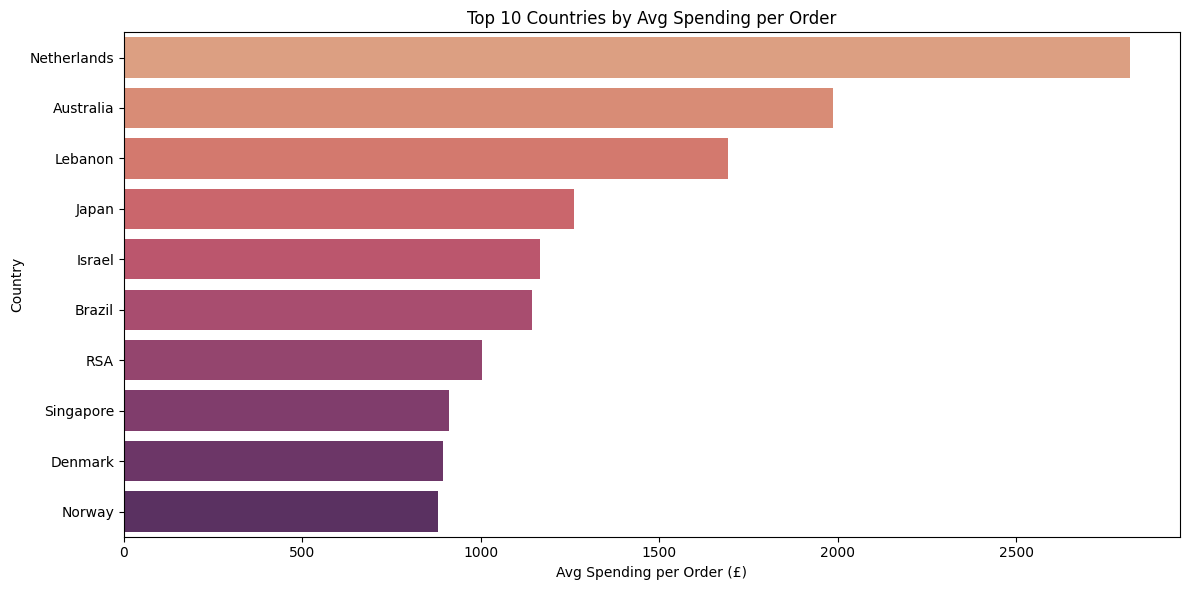

In [16]:
# Total per country / total orders per country
country_avg_spending = df.groupby('Country').agg({'TotalPrice': 'sum', 'InvoiceNo': 'nunique'})
country_avg_spending['AvgSpendingPerOrder'] = country_avg_spending['TotalPrice'] / country_avg_spending['InvoiceNo']
top_avg_spending = country_avg_spending.sort_values('AvgSpendingPerOrder', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_avg_spending['AvgSpendingPerOrder'], y=top_avg_spending.index, palette='flare')
plt.title('Top 10 Countries by Avg Spending per Order')
plt.xlabel('Avg Spending per Order (£)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

### RFM Analysis and Scoring 

This section calculates the RFM (Recency, Frequency, Monetary) metrics for each customer to understand their purchasing behavior. We define Recency as days since the last purchase, Frequency as the number of purchases, and Monetary as the total spending. Each metric is then converted into a score from 1 to 5 using quantiles, and combined into a final RFM score. This helps in identifying high-value and low-engagement customers for targeted marketing.


In [17]:
df = raw_df.copy()
df = df.dropna(subset=['CustomerID'])
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']
# Create a reference date (1 day after the last transaction)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
# RFM Calculation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days, # Recency : less is better 
    'InvoiceNo': 'nunique', # Frequency : more is better
    'TotalPrice': 'sum' # Monetary : more is better
    }).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
# RFM Scoring using quantiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels = [5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method ='first'), 5, labels = [1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels = [1, 2, 3, 4, 5])
# Combine RFM scores
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis = 1).astype(int)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,12346.0,326,2,0.00,1,2,1,121,4
1,12347.0,2,7,4310.00,5,4,5,545,14
2,12348.0,75,4,1797.24,2,3,4,234,9
3,12349.0,19,1,1757.55,4,1,4,414,9
4,12350.0,310,1,334.40,1,1,2,112,4


### Visualizing RFM Score Distribution

This histogram displays the distribution of RFM scores among all customers. Higher RFM scores indicate customers who purchased recently, frequently, and spent more — often considered loyal or high-value customers. A concentration of customers at the lower end may suggest a need to re-engage or analyze drop-off reasons.


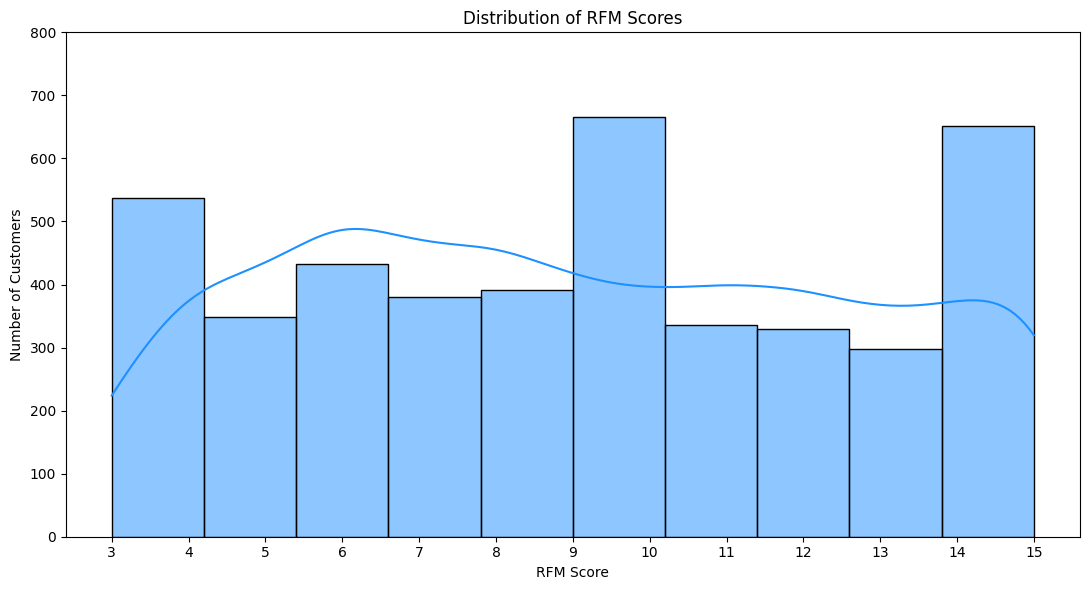

In [18]:
plt.figure(figsize=(11,6))
sns.histplot(rfm['RFM_Score'], bins=10, kde = True, color='dodgerblue')
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')
plt.xticks(range(rfm['RFM_Score'].min(), rfm['RFM_Score'].max() + 1))
plt.yticks(range(0, 900, 100))
plt.tight_layout()
plt.show()

###  Assigning Customer Segments Based on RFM Scores

Using RFM scores, we classify customers into meaningful segments based on their purchasing behavior. This segmentation allows businesses to tailor marketing efforts more effectively, from rewarding loyal customers to re-engaging those who are at risk of churning.

#### Customer Segments Defined:

- **Champions**  
  Customers with the highest combined RFM score (13 or above). They purchase often, spend the most, and bought recently.

- **Loyal**  
  Customers with an RFM score between 10 and 12. They consistently purchase and are valuable to retain through loyalty programs.

- **Potential Loyalist**  
  Customers who have purchased recently (R ≥ 4) and moderately often (F ≥ 3), showing signs of becoming loyal if nurtured.

- **Need Attention**  
  Customers with moderate recency (R ≥ 3) but low frequency (F ≤ 2). They might convert with targeted engagement.

- **At Risk**  
  Customers with older last purchases (R ≤ 2) but high frequency (F ≥ 3). They were once active but may be drifting away.

- **Lost**  
  Customers who haven't purchased in a long time (R = 1) and very rarely (F = 1). Re-engagement campaigns are needed.

- **Others**  
  Customers who don't clearly fit any of the above patterns. This group may require a custom strategy or further investigation.


In [19]:
def segment_customer(row):
    r = int(row['R_Score'])
    f = int(row['F_Score'])
    score = row['RFM_Score']

    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal'
    elif r >= 4 and f >= 3:
        return 'Potential Loyalist'
    elif r >= 3 and f <= 2:
        return 'Need Attention'
    elif r <= 2 and f >= 3:
        return 'At Risk'
    elif r == 1 and f == 1:
        return 'Lost'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

### Visualizing Customer Segment Counts

This bar chart displays the number of customers in each segment defined by RFM analysis. Each segment reflects unique customer behavior, such as high-value "Champions" or low-engagement "Lost" customers.

By analyzing this distribution, we can assess the overall health of the customer base and identify where to focus retention or engagement strategies. A higher count in "Loyal" and "Potential Loyalist" segments indicates promising long-term value.


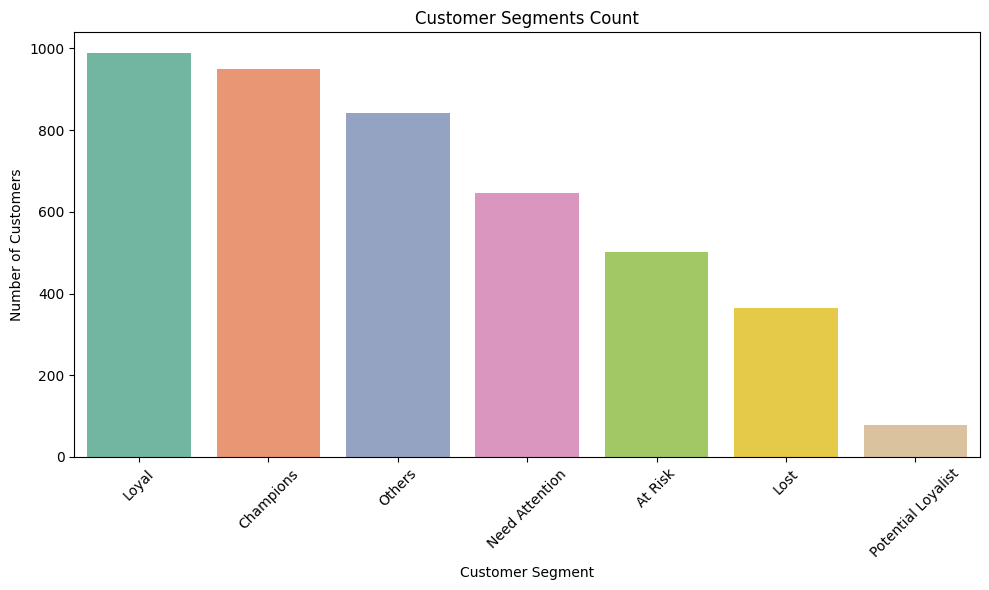

In [20]:
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(data=segment_counts, x='Segment', y='Count', palette='Set2')
plt.title('Customer Segments Count')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Finding Optimal Clusters Using the Elbow Method (K-Means)

To segment customers based on their RFM values, we use the K-Means clustering algorithm. Since K-Means is sensitive to data scale, we first standardize the RFM features using `StandardScaler`.

Then, we apply the Elbow Method to determine the ideal number of clusters (k). This is done by plotting the inertia (sum of squared distances within clusters) against various k values. The “elbow” point, where the rate of decrease sharply changes, indicates the optimal number of clusters that balances compactness and efficiency.

Normalize RFM Features

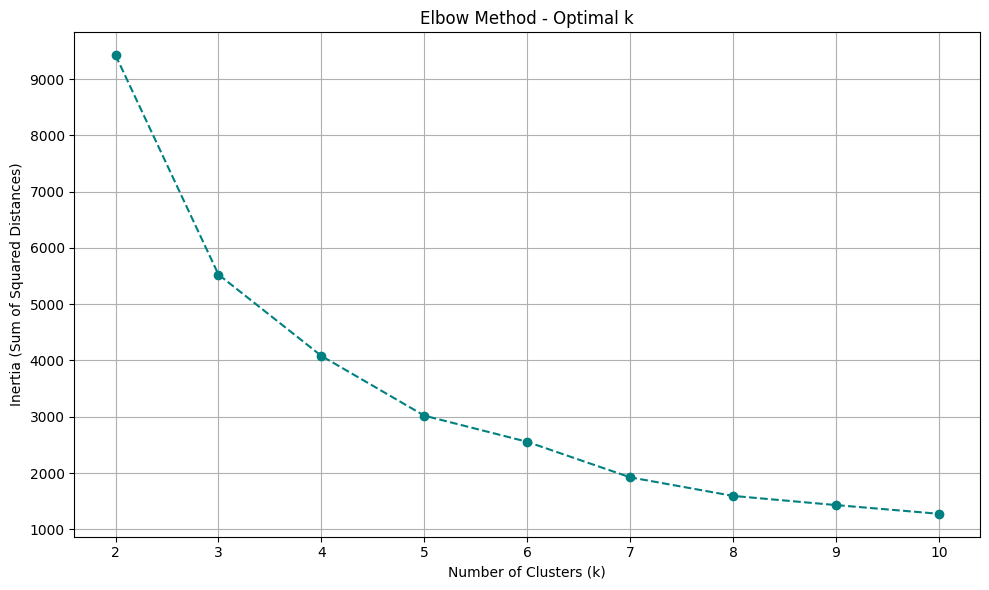

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


rfm_for_clustering = rfm[['Recency', 'Frequency', 'Monetary']]

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_clustering)


inertia = []  # stores the sum of squared distances for each K
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='teal')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method - Optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()


### Evaluating Clustering Quality with Silhouette Scores

After applying the Elbow Method to determine a potential number of clusters, we further validate clustering quality using the Silhouette Score.

The Silhouette Score measures how similar each point is to its own cluster compared to other clusters. It ranges from -1 to 1, where higher values indicate better-defined and more separated clusters.

By plotting the silhouette score for each value of k (number of clusters), we can identify the optimal clustering configuration that not only minimizes inertia but also maintains high cohesion within clusters and separation between them.


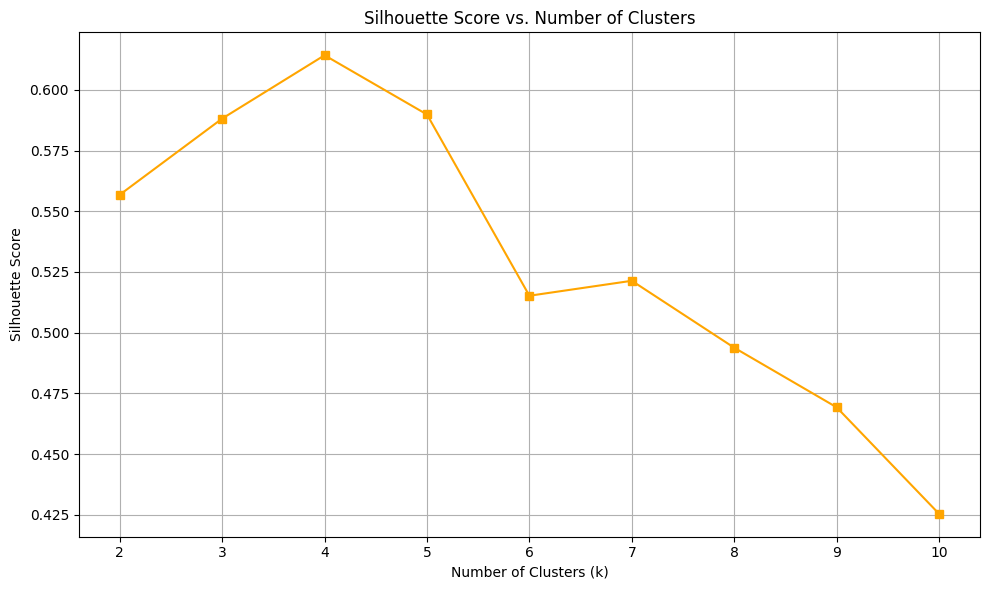

In [22]:
# Evaluate clustering quality with silhouette scores
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='s', linestyle='-', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()


### Applying K-Means Clustering for Customer Segmentation 

We applied K-Means clustering on the standardized RFM data to automatically segment customers into meaningful groups.

1. K-Means with k=4:
   We used K=4 based on prior analysis (Elbow + Silhouette methods). The model assigns each customer to one of the 4 clusters based on Recency, Frequency, and Monetary value.

2. Cluster Profiling:
   We computed average RFM values for each cluster to interpret and label them based on customer behavior. Clusters were renamed accordingly:
   - Cluster 2 → Champions
   - Cluster 3 → Loyal Customers
   - Cluster 0 → Potential Loyalists
   - Cluster 1 → At Risk

3. Visualizing Customer Segments:
   A scatter plot (Recency vs. Monetary) with color-coded segments illustrates how customer groups differ. This helps identify high-value customers and those needing attention at a glance.

Cluster Summary:
          Recency  Frequency  Monetary  RFM_Score  NumCustomers
Cluster                                                       
2            7.7       89.0  182182.0       14.8             6
3            9.2       40.7   18442.0       14.8           110
0           41.6        4.8    1478.5       10.1          3169
1          248.0        1.8     453.5        5.2          1087


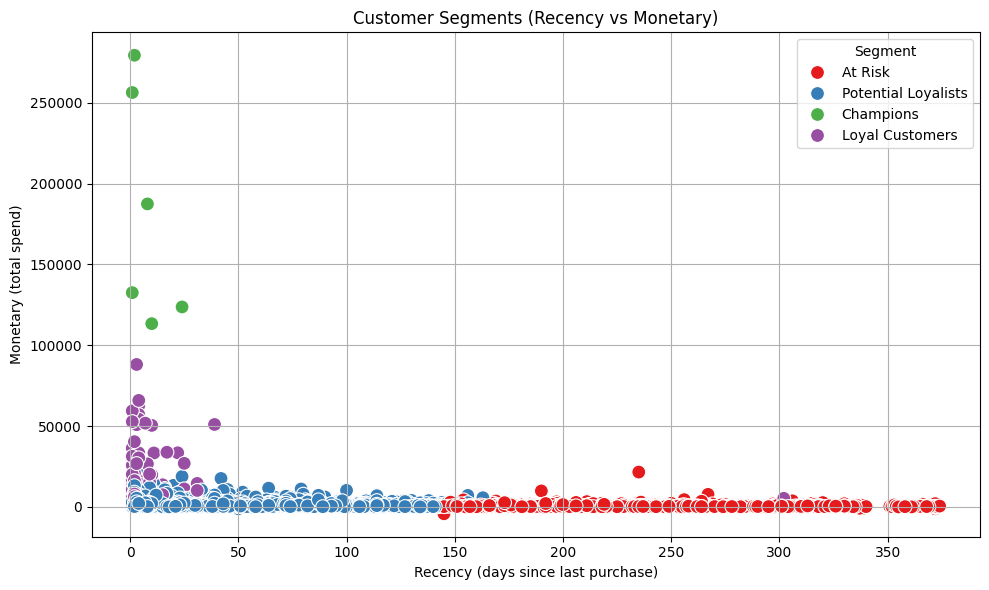

In [23]:
# 1. Apply K-Means with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)  # Replace 'auto' with 10 for compatibility
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 2. Summary stats for each cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'RFM_Score': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'NumCustomers'}).round(1)

# Optional: Check summary to ensure cluster numbers match the mapping you're applying
print("Cluster Summary:\n", cluster_summary.sort_values('Monetary', ascending=False))

#Map cluster numbers to segment names manually (adjust after seeing actual summary)
cluster_map = {
    2: 'Champions',
    3: 'Loyal Customers',
    0: 'Potential Loyalists',
    1: 'At Risk'
}

#mapping names
rfm['Segment'] = rfm['Cluster'].map(cluster_map)

#Recency vs Monetary with segment names
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='Set1', s=100)
plt.title('Customer Segments (Recency vs Monetary)')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Monetary (total spend)')
plt.legend(title='Segment')
plt.grid(True)
plt.tight_layout()
plt.show()


### RFM Metrics Correlation

This heatmap visualizes the correlation between Recency, Frequency, and Monetary values.

- **Recency vs Frequency**: This shows if recent customers are more likely to make frequent purchases.
- **Recency vs Monetary**: This explores if recent customers tend to spend more.
- **Frequency vs Monetary**: This reveals if customers who purchase frequently also tend to spend more.

The correlation values provide insights into the relationship between these metrics, which can help shape targeted marketing efforts.


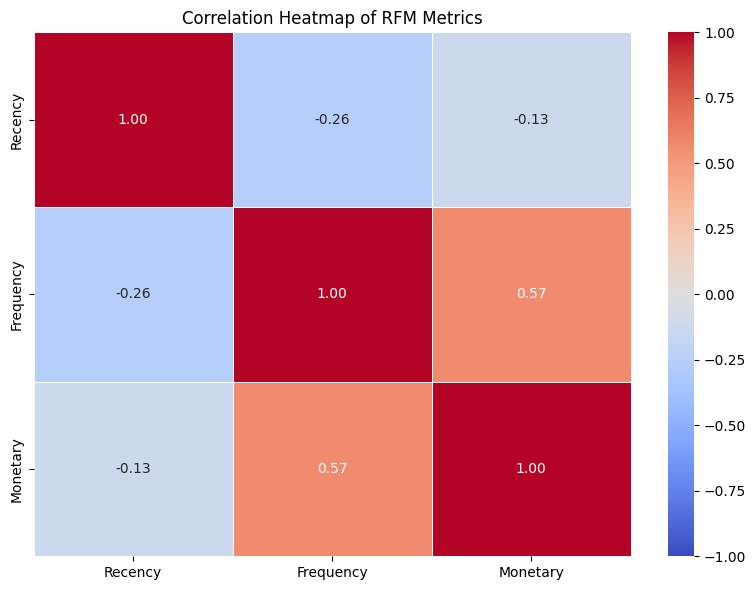

In [34]:
# Plotting the correlation heatmap between Recency, Frequency, and Monetary
rfm_corr = rfm[['Recency', 'Frequency', 'Monetary']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(rfm_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Correlation Heatmap of RFM Metrics')
plt.tight_layout()
plt.show()


### Time-Based Segmentation and RFM Integration

In this step, we enhance the transactional dataset with time-based and customer segmentation attributes to prepare for trend and behavioral analysis:

- **Monthly and Quarterly Time Features**:  
  - We extract the `Month` and `Quarter` from the `InvoiceDate` using the `to_period()` method.  
  - These new features allow us to analyze seasonality, trends, and sales performance over time.

- **Customer Segmentation Merge**:  
  - We merge the `rfm` table (which contains `CustomerID` and their corresponding RFM-based `Segment`) into the main dataframe `df`.  
  - This step associates each transaction with its customer segment, enabling segmented analysis of purchasing behavior.

In [25]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')
df['Quarter'] = df['InvoiceDate'].dt.to_period('Q')
segmented_df = df.merge(rfm[['CustomerID', 'Segment']], on='CustomerID', how='left')

### Monthly Purchase Frequency by Customer Segment

In this section, we visualize how different customer segments behave over time by analyzing the number of unique orders placed each month:

- **Grouping and Aggregation**:
  - We group the `segmented_df` by `Month` and `Segment` and count the number of unique `InvoiceNo` values to capture monthly purchase frequency.
  - This metric indicates how active each customer segment is over time.

- **Visualization**:
  - A line plot is created using Seaborn to show the trend of monthly order counts by segment.
  - Different segments are color-coded for clarity, and data points are marked to highlight monthly changes.

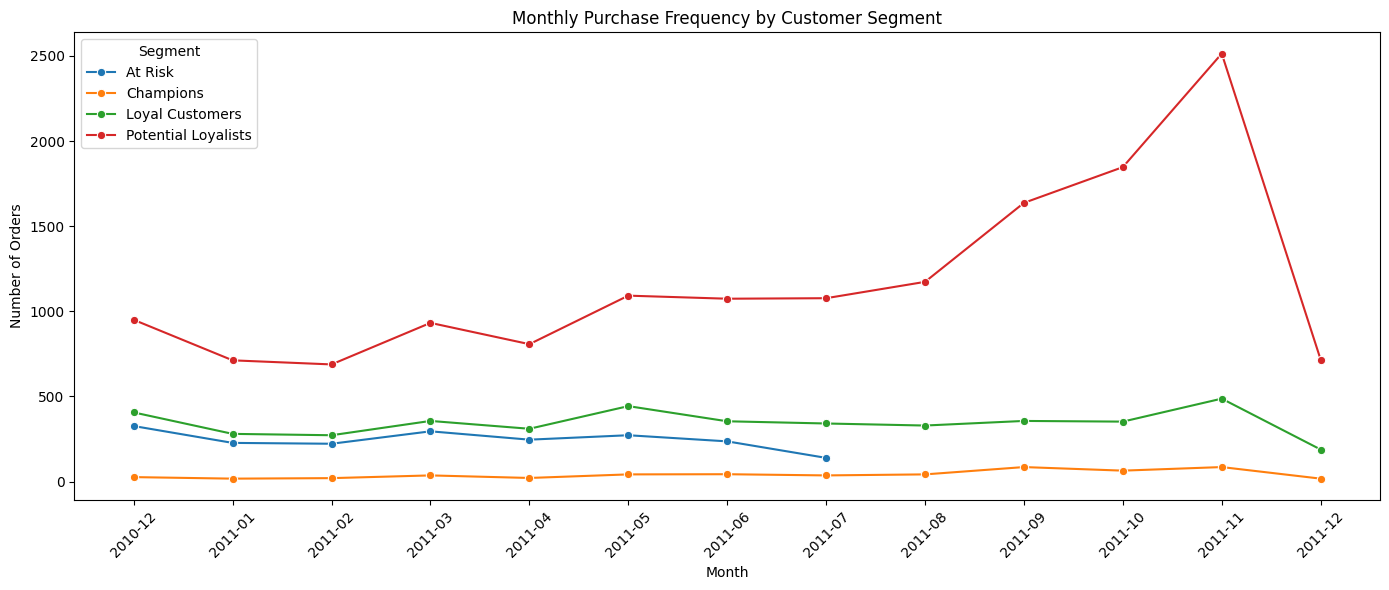

In [26]:
monthly_segment_orders = segmented_df.groupby(['Month', 'Segment'])['InvoiceNo'].nunique().reset_index()
monthly_segment_orders['Month'] = monthly_segment_orders['Month'].astype(str)

plt.figure(figsize=(14,6))
sns.lineplot(data=monthly_segment_orders, x='Month', y='InvoiceNo', hue='Segment', marker='o')
plt.title('Monthly Purchase Frequency by Customer Segment')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### RFM Cluster Profiling: Mean Recency, Frequency, and Monetary Values

This step summarizes the behavioral characteristics of each customer **cluster** using the **average values** of the RFM metrics:

- **Recency**: Average number of days since the last purchase — lower is better.
- **Frequency**: Average number of transactions — higher means more loyal customers.
- **Monetary**: Average revenue generated by customers in the cluster — higher indicates more profitable customers.

**Why this matters**:
By reviewing the mean values of `Recency`, `Frequency`, and `Monetary` for each cluster, we can clearly understand the **value and engagement level** of different customer groups. This helps in:
- Prioritizing high-value clusters
- Identifying at-risk or inactive customers
- Tailoring marketing strategies for each group


In [27]:
print(rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean())

            Recency  Frequency       Monetary
Cluster                                      
0         41.606500   4.802461    1478.515539
1        247.951242   1.805888     453.488888
2          7.666667  89.000000  182181.981667
3          9.181818  40.672727   18441.961455


Segment Distribution

### Visualizing Customer Segment Distribution

We use a countplot to visualize how customers are distributed across different RFM-based segments. This helps quickly identify the most and least populated segments for strategic focus.


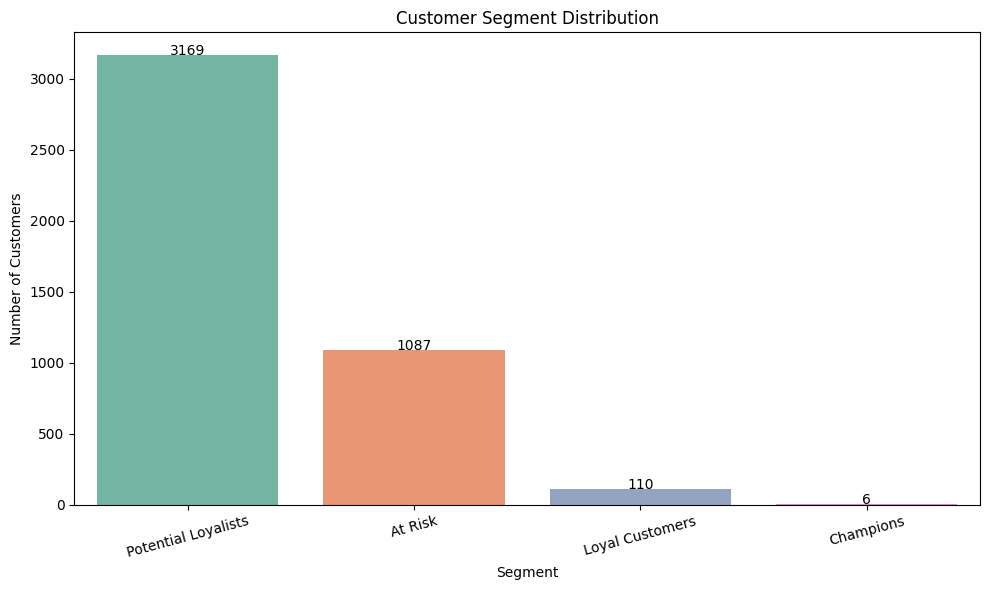

In [28]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='Set2')
plt.title('Customer Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=15)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 2, int(height), ha="center")

plt.tight_layout()
plt.show()


### Correlation Heatmap of RFM Features

We use a heatmap to visualize the correlation between Recency, Frequency, Monetary, and the overall RFM Score. This helps us understand how these features interact.

- A **negative correlation** between Recency and the other variables means customers who purchased recently (low recency) tend to spend more and purchase more often.
- A **positive correlation** between Frequency, Monetary, and RFM Score suggests that frequent buyers also tend to spend more and score higher overall.
- The heatmap provides a quick insight into which behaviors are linked, helping us validate the design of our scoring system and understand key customer traits.


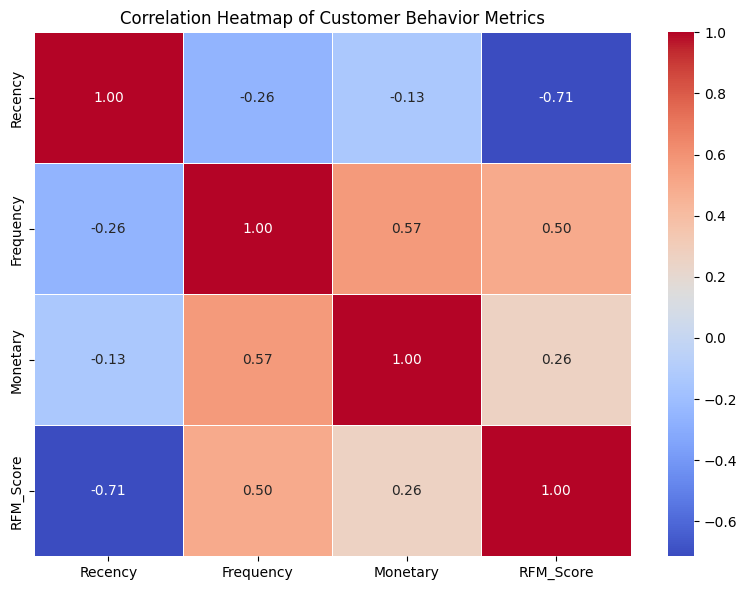

In [29]:
plt.figure(figsize=(8, 6))
corr = rfm[['Recency', 'Frequency', 'Monetary', 'RFM_Score']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Customer Behavior Metrics')
plt.tight_layout()
plt.show()
